### 1 El viejo XOR


### a) XOR Aleatorio

El problema se denomina XOR ya que las clases se asignan realizando la operación lógica XOR entre las coordenadas de cada punto. El resultado de una operación XOR (OR exclusivo) es verdadero cuando los inputs son distintos y falso cuando son iguales, en este caso se toma como input el signo de cada coordenada de puntos (x,y) en el plano.

Las coordenadas toman valores entre -1 y 1, los cuadrantes con igual signo (I y III) tienen como resultado de XOR falso y los cuadrantes donde x e y tienen signos distintos (II y IV) tienen como resultado de XOR verdadero, asi que se toman estos resultados como las etiquetas de las clases.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def do_XOR(n=1000,noisy_n=100,svm=True):
    rng = np.random.RandomState(0)
    X_train = rng.uniform(low=-1.0,high=1.0,size=(n,2))
    Y_train = np.logical_xor(X_train[:,0] > 0, X_train[:,1] > 0)
    Y_train = 2*Y_train-1 if svm else Y_train
    X_noisy= rng.uniform(low=-0.8,high=0.2,size=(noisy_n,2))
    Y_noisy = -1*np.logical_xor(X_noisy[:,0] > 0, X_noisy[:,1] > 0) + 1
    Y_noisy = 2*Y_noisy-1 if svm else Y_noisy
    X_train = np.vstack((X_train, X_noisy))
    Y_train = np.hstack((Y_train, Y_noisy))
    X_test = rng.uniform(low=-1.0,high=1.0,size=(n,2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    Y_test = 2*Y_test - 1 if svm else Y_test    
    return X_train,Y_train,X_test,Y_test

X_train,Y_train,X_test,Y_test = do_XOR()

### b) SVM Lineal

Queremos comprobar que el problema no se puede resolver satisfactoriamente con una SVM lineal, la función *plot_classifier* muestra los datos con un modelo, también se creó la función *show_data* para previsualizar los datos. 

A partir de la visualización de los datos y por las características del problema está claro que no se pueden separar con una recta, pero se probará experimentalmente que no se puede obtener un resultado al menos 50% superior a una clasificación aleatoria, ya que las son generadas aproximadamente 50/50, se requiere una precisión sobre 75% para que se considere un resultado satisfactorio.

In [2]:
def plot_classifier(clf,X_train,Y_train,X_test,Y_test, model_type, title = ""):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(5, 5))
    axis.scatter(X_train[:,0],X_train[:,1],s=5,c=Y_train,zorder=10,cmap='gray')
    axis.scatter(X_test[:,0],X_test[:,1],s=15,c=Y_test,zorder=10,cmap='gray')
    XX, YY = np.mgrid[-1:1:200j, -1:1:200j]
    if model_type == 'svm':
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    elif model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: 
        raise ValueError('model type not supported')

    Z = Z.reshape(XX.shape)
    Zplot = Z > 0 if model_type == 'svm' else Z > 0.5
    axis.pcolormesh(XX, YY, Zplot, cmap="YlGn")
    axis.contour(XX, YY, Z, alpha=1, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],levels=[-1, 0, 1])
    plt.title(title, fontsize = 14)
    #plt.show()
    return f

def show_data(x, y, title):
    plt.figure(figsize=(5, 5))    
    plt.scatter(x[y==-1, 0], x[y==-1, 1], label=-1, c="r")
    plt.scatter(x[y==1,0], x[y==1,1], label=1, c="g")

    plt.title(title, fontsize = 16)
    plt.xlabel('x', fontsize = 14)
    plt.ylabel('y', fontsize = 14)
    leg = plt.legend(loc='upper right', fancybox=True)

    plt.show()

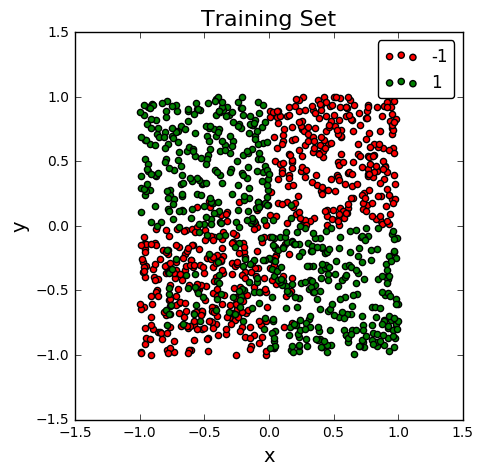

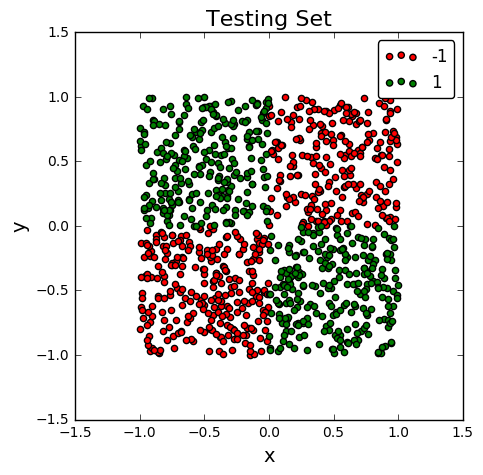

In [3]:
show_data(X_train, Y_train, 'Training Set')
show_data(X_test, Y_test, 'Testing Set')

En la primera muestra de datos se puede observar el ruido introducido en el training set, mientras que el training set tiene las clases divididas claramente en los 4 cuadrantes.

In [4]:
from sklearn.metrics import classification_report
def score_the_model(model, x, y, xt, yt, text):
    acc_tr = model.score(x, y)
    acc_test = model.score(xt, yt)
    print "Training Accuracy %s: %f"%(text, acc_tr)
    print "Test Accuracy %s: %f"%(text, acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=['-1','+1']))

from sklearn.svm import LinearSVC
def do_SVM(x,y,xt,yt,i=False):
    Cs = [0.01,0.1,10,100,1000]
    if i:
        for C in Cs:
            print "El valor de C que se esta probando: %f"%C
            model = LinearSVC(C=C)
            model = model.fit(x, y)
            score_the_model(model,x,y,xt,yt,"SVM")
    else:
        model = LinearSVC(C=1000.0) #se eligió la mejor de las anteriores
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"SVM")
    return model


Training Accuracy SVM: 0.667273
Test Accuracy SVM: 0.623000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.72      0.37      0.49       489
         +1       0.59      0.86      0.70       511

avg / total       0.65      0.62      0.60      1000



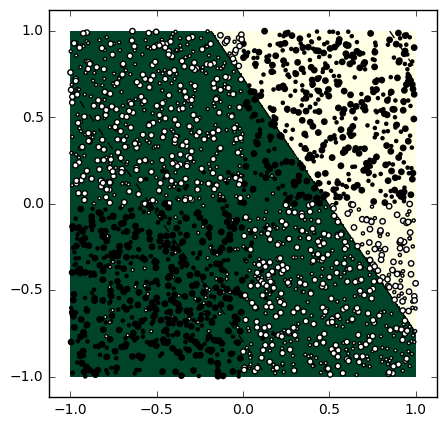

In [5]:
svm_model = do_SVM(X_train, Y_train, X_test, Y_test, False)
fig = plot_classifier(svm_model,X_train,Y_train, X_test, Y_test, 'svm')

La SVM, al realizar varias pruebas, mantiene su accuracy cercana al 50% y muchas veces es peor, por lo que podría ser incluso mejor utilizar un clasificador aleatorio en algunos casos. Queda demostrado con las prubeas que la SVM lineal no clasifica el problema de manera satisfactoria.

### c) SVC

In [6]:
from sklearn.svm import SVC
def do_SVC(x,y,xt,yt,k):
    Cs = np.logspace(-2, 4,base=2, num=7)
    best = 0
    test_acc = []
    train_acc = []
    
    for C in Cs:
        if k == 'rbf':
            clf = SVC(C, kernel=k)
        elif k == 'poly':
            clf = SVC(C, kernel=k, degree=2, coef0=1)
        
        clf.fit(x,y)
        test_acc.append(clf.score(xt,yt))
        train_acc.append(clf.score(x,y))
        
        if(clf.score(xt,yt) > best):
            best = clf.score(xt,yt)
            model = clf
        
    return model, test_acc, train_acc
        

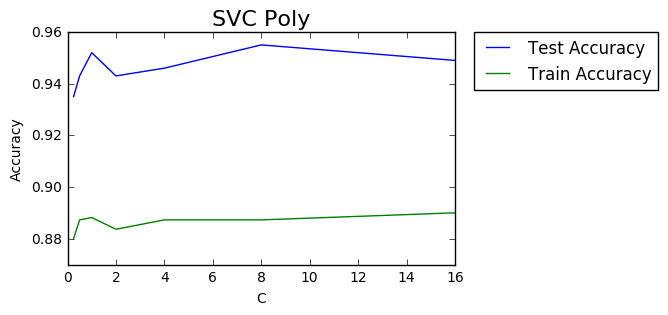

In [7]:
modelo_poly, test_acc_poly, train_acc_poly = do_SVC(X_train, Y_train, X_test, Y_test, 'poly')
Cs = np.logspace(-2, 4,base=2, num=7)
plt.figure(figsize=(5,3))
ax = plt.gca()
ax.plot(Cs,test_acc_poly,label='Test Accuracy')
ax.plot(Cs,train_acc_poly,label='Train Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('SVC Poly', fontsize= 16)
#plt.ylim([0,1])
ax.set_xscale('linear')
plt.show()

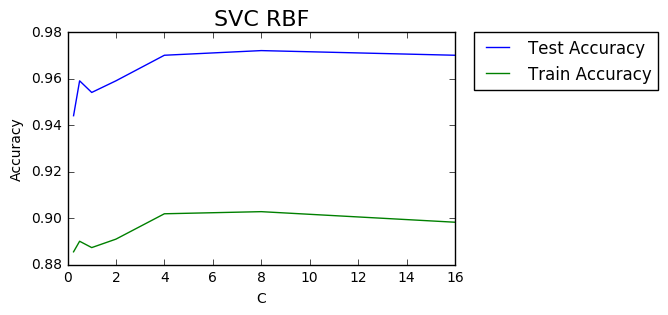

In [8]:
modelo_rbf, test_acc_rbf, train_acc_rbf = do_SVC(X_train, Y_train, X_test, Y_test, 'rbf')
plt.figure(figsize=(5,3))
ax = plt.gca()
ax.plot(Cs,test_acc_rbf,label='Test Accuracy')
ax.plot(Cs,train_acc_rbf,label='Train Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('SVC RBF', fontsize= 16)
#plt.ylim([0,1])
ax.set_xscale('linear')
plt.show()

Se utilizará $C=8$ ya que es el que obtiene la mejor accuracy en el set de pruebas con ambos kernel. 

A continuación se puede ver el plot de la SVC con kernel poly:

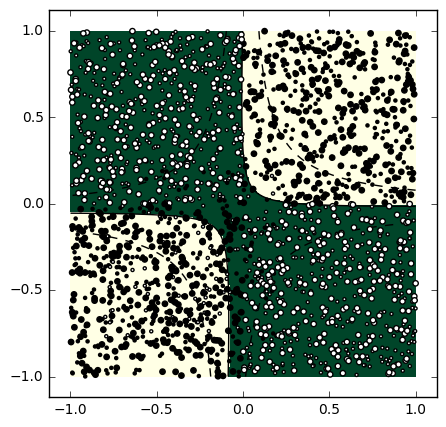

In [9]:
fig2 = plot_classifier(modelo_poly,X_train,Y_train, X_test, Y_test, 'svm')

Y las fronteras del modelo con kernel rbf:

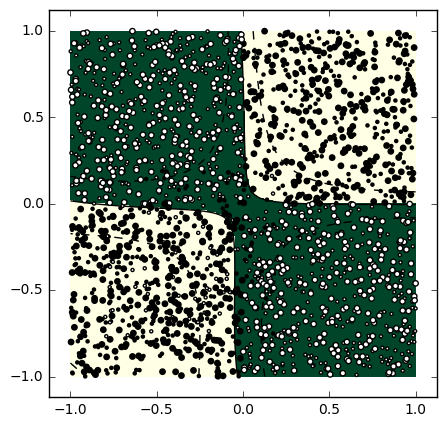

In [10]:
fig3 = plot_classifier(modelo_rbf,X_train,Y_train, X_test, Y_test, 'svm')

Las fronteras son de forma similar, pero el kernel rbf tiene una accuracy de 97.2% mientras que el poly tiene sólo 95.5% de precisión. Ya que el problema está "hecho a mano", las fronteras se ajustan bien, pero el kernel gaussiano puede tender a overfitting.

Independiente del kernel, el método no lineal se ajusta fácilmente a las fronteras del problema del XOR.

### d) Redes neuronales - 1 Neurona

In [11]:
X_train,Y_train,X_test,Y_test = do_XOR(svm = False)

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], init='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, Y_train, nb_epoch=25, batch_size=100, verbose=0)
scores = model.evaluate(X_test,Y_test)
test_acc = scores[1]

Using Theano backend.


  32/1000 [..............................] - ETA: 0s

Test Acuracy:  0.466


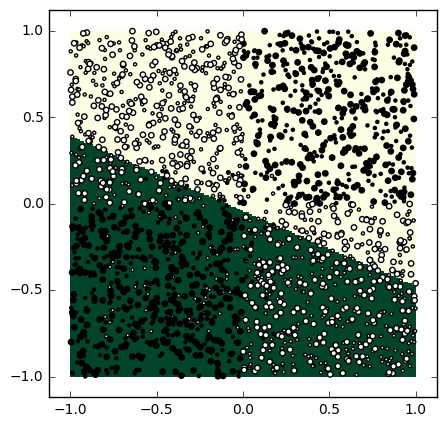

In [13]:
print "Test Acuracy: ", test_acc
fig5 = plot_classifier(model,X_train,Y_train, X_test, Y_test, 'ann')

Tras probar varias funciones de activación y distintos parámetros, en la mayoría de los casos se clasifican todos los puntos en una clase para obtener cercano al 50% de accuracy, pero nunca se resuelve satisfactoriamente el problema. Algunos modelos resuelven el problema con fronteras lineales pero naturalmente el resultado es poco satisfactorio.

### e) Redes neuronales - 1 capa escondida

In [14]:
'''
n_h = 8
model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, Y_train, nb_epoch=50, batch_size=100, verbose=0)
scores = model.evaluate(X_test,Y_test)
test_acc = scores[1]
'''
def do_ann(x,y,xt,yt):
    nhs = np.logspace(1, 7,base=2, num=7)
    test_acc2 = []
    train_acc2 = []
    best = 0
    
    for n_h in nhs:        
        model = Sequential()
        model.add(Dense(n_h, input_dim=X_train.shape[1], init='uniform', activation='relu'))
        model.add(Dense(1, init='uniform', activation='sigmoid'))
        model.compile(optimizer=SGD(lr=1), loss = 'binary_crossentropy', metrics = ['accuracy'])
        model.fit(x, y, nb_epoch=50, batch_size=100, verbose=0)
        
        scores2 = model.evaluate(x,y)
        train_acc2.append(scores2[1])
        
        scorest = model.evaluate(xt,yt)
        test_acc2.append(scorest[1])
        #print scorest
        
        if(scorest[1] > best):
            best = scorest[1]
            best_model = model
        
        p_title = "ANN n_h: " + str(n_h)
        f = plot_classifier(model, x,y,xt,yt, 'ann', p_title)
        figname = "ann n_h "+str(n_h)+".png"
        f.savefig(figname)
    
    return best_model, test_acc2, train_acc2

C:\Users\Manuel\Anaconda2\lib\site-packages\keras\backend\theano_backend.py:141: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return variable(np.random.uniform(low=low, high=high, size=shape),
C:\Users\Manuel\Anaconda2\lib\site-packages\keras\backend\theano_backend.py:117: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return variable(np.zeros(shape), dtype, name)


  32/1000 [..............................] - ETA: 0s

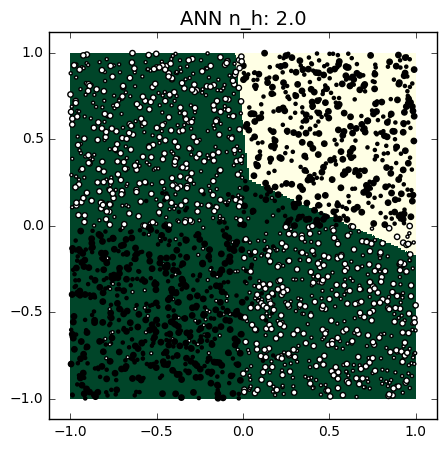

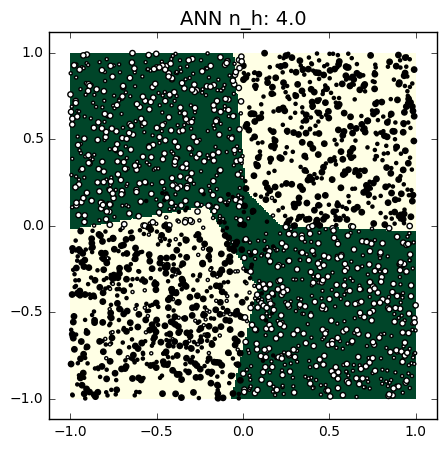

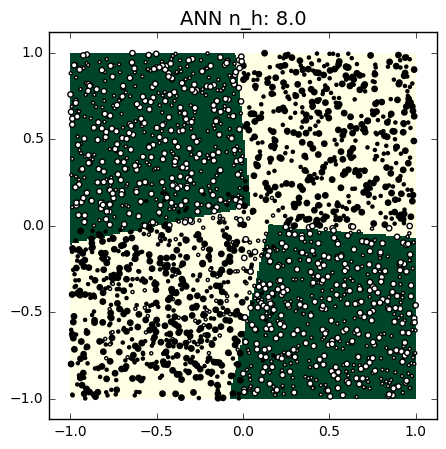

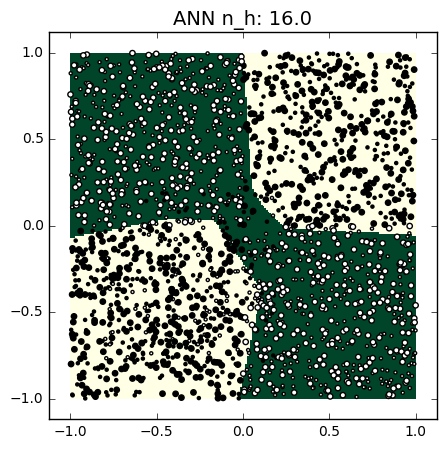

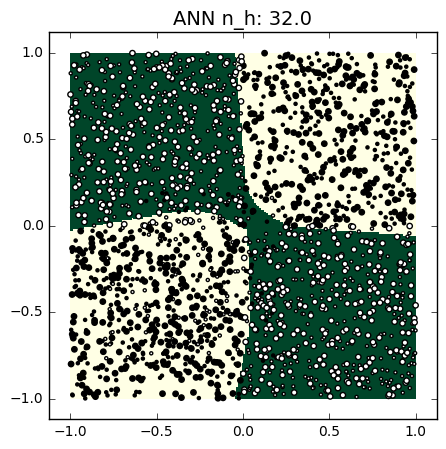

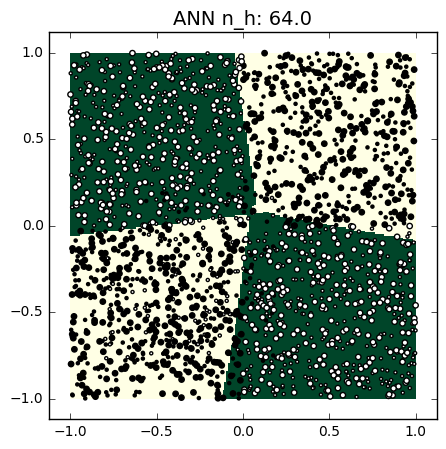

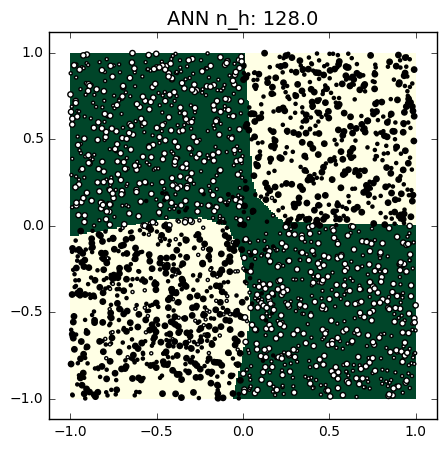

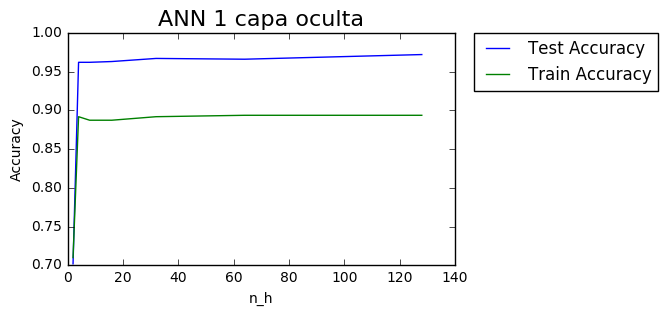

Max test accuracy:  0.972  en n_h:  128.0


In [15]:
modelo, test_acc_ann, train_acc_ann = do_ann(X_train, Y_train, X_test, Y_test)
nhs = np.logspace(1, 7,base=2, num=7)
plt.figure(figsize=(5,3))
ax = plt.gca()
ax.plot(nhs,test_acc_ann,label='Test Accuracy')
ax.plot(nhs,train_acc_ann,label='Train Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('n_h')
plt.ylabel('Accuracy')
plt.title('ANN 1 capa oculta', fontsize= 16)
#plt.ylim([0,1])
ax.set_xscale('linear')
plt.show()
print "Max test accuracy: ", max(test_acc_ann), " en n_h: ", nhs[test_acc_ann.index(max(test_acc_ann))]

Se utiliza activación sigmoidal en la salida ya que es una predicción binaria. Se crea una aproximación muy buena a los limites del XOR llegando hasta un 97% de accuracy, se observa en la comparación de los errores que el modelo no se sobreajusta al ruido introducido en el set de entrenamiento.

En general se observa que un n_h mayor es mejor, pero la mejora en calidad no es muy significativa después de cierto umbral, en la práctica se podría trabajar con 8 o 16 neuronas para tener un buen resultado sin comprometer mucho el tiempo de ejecución.

### f) Stump

In [16]:
from sklearn.tree import DecisionTreeClassifier as Tree

def do_Tree(x,y,xt,yt,n_t):
    clf=Tree(criterion='gini',splitter='best',max_depth=n_t)
    clf.fit(x,y)
    acc_train = clf.score(x, y)
    acc_test = clf.score(xt,yt)
    #print "Train Accuracy = %f"%acc_train
    #print "Test Accuracy = %f"%acc_test
    #print "Depth = %d"%clf.tree_.max_depth

    #plot_classifier(clf,X_train,Y_train,X_test,Y_test,'tree', u'Árbol de 1 nivel')
    #score_the_model(clf, X_train, Y_train, X_test, Y_test, 'Arbol stump')
    return clf, acc_train, acc_test 

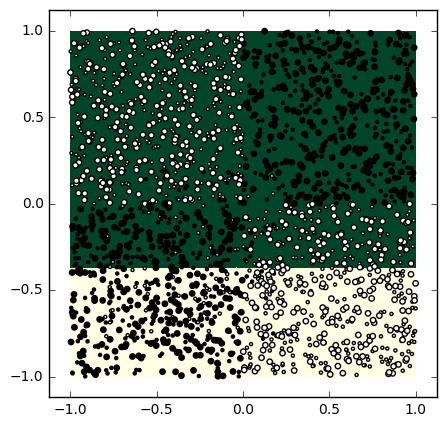

In [17]:
stump, acc_train, acc_test = do_Tree(X_train, Y_train, X_test, Y_test, 1)
fig7 = plot_classifier(stump,X_train,Y_train,X_test,Y_test,'tree')

Es claro que un árbol de 1 solo nivel no podrá clasificar correctamente el problema, ya que en un solo nivel puede tomar una decisión con una variable, clasificando si el punto es mayor o menor a un threshold. En otras palabras, en 2D sólo puede crear un limite vertical u horizontal, lo que no clasificará bien el problema.

### g) arbol con distinta profundidad

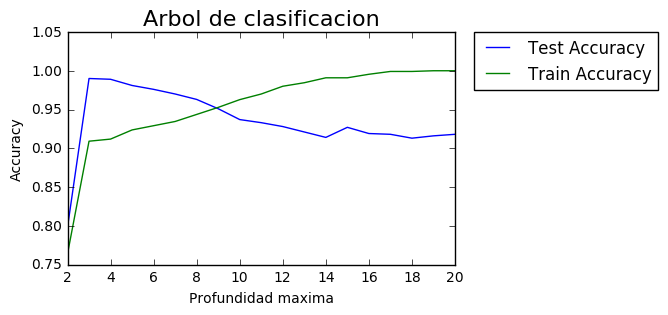

Max test accuracy:  0.99  en depth:  3


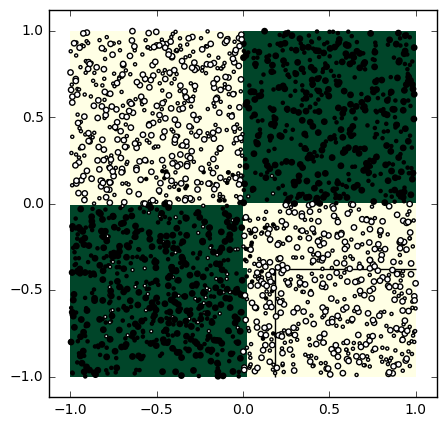

In [18]:
best_acc = 0
test_acc_tree = []
train_acc_tree = []

for i in range(2,21):
    clf, acc_train, acc_test = do_Tree(X_train, Y_train, X_test, Y_test, i)
    test_acc_tree.append(acc_test)
    train_acc_tree.append(acc_train)
    
    if(acc_test > best_acc):
        best_acc = acc_test
        best_tree = clf
        
plt.figure(figsize=(5,3))
ax = plt.gca()
ax.plot(range(2,21),test_acc_tree,label='Test Accuracy')
ax.plot(range(2,21),train_acc_tree,label='Train Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Profundidad maxima')
plt.ylabel('Accuracy')
plt.title('Arbol de clasificacion', fontsize= 16)
#plt.ylim([0,1])
ax.set_xscale('linear')
plt.show()
print "Max test accuracy: ", max(test_acc_tree), " en depth: ", range(2,21)[test_acc_tree.index(max(test_acc_tree))]

fig8 = plot_classifier(best_tree,X_train,Y_train,X_test,Y_test,'tree')

En el error se observa claramente que al agregar niveles al árbol, las fronteras se sobreajustan al ruido agregado en el set de entrenamiento, con 3 niveles el árbol es óptimo para este problema y logra una clasificación casi perfecta en el set de pruebas.

Finalmente, se pueden exportar los árboles para ver las reglas que considera el clasificador.

In [19]:
from sklearn import tree
tree.export_graphviz(best_tree, out_file='tree.dot')
tree.export_graphviz(stump, out_file = 'stump.dot')
#los árboles se pueden ver en http://www.webgraphviz.com/